# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime as d
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_years_df = pd.DataFrame([])

for year in range(2015, 2022):
    with open(f'Data/df_{year}_cleaned.pickle', "rb") as file:
        df_years = pickle.load(file)
    all_years_df = all_years_df.append(df_years, ignore_index=True)

all_years_df.rename(columns={"deals": "amount"}, inplace=True)
all_years_df.sample(3)

C:\Users\isaev\AppData\Local\Temp\ipykernel_964\2506910825.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_years_df = all_years_df.append(df_years, ignore_index=True)


,datetime,ticker,amount,price,user,cf,date
4006614,2019-10-07 18:03:00,RUAL,10,27.445,1_210727,-274.45,2019-10-07
4610510,2020-10-27 20:35:00,MOEX,10,140.950,1_240951,-1409.50,2020-10-27
5070370,2020-11-30 20:26:00,QIWI,-10,1102.500,1_251992,11025.00,2020-11-30


In [3]:
df_2022 = pd.read_csv("stock_market_trades.csv", sep=";")

df_2022["timestamp"] = pd.to_datetime(df_2022["timestamp"])
df_2022["date"] = pd.to_datetime([d.date() for d in df_2022["timestamp"]])
df_2022["cf"] = -df_2022["amount"]*df_2022["price"]

df_2022 = df_2022.reindex(columns=["timestamp", "ticker", "amount", "price", "id", "cf", "date"])
df_2022.rename(columns={"id": "user", "timestamp": "datetime"}, inplace=True)
df_2022["user"] = df_2022["user"].astype(str)

df_result = pd.concat([df_2022, all_years_df]).reset_index(drop = True)
df_result["value"] = -df_result["cf"]
df_result.sample(3)

,datetime,ticker,amount,price,user,cf,date,value
922755,2015-10-30 16:38:00,MTSS,200,208.80,1_53072,-41760.0,2015-10-30,41760.0
3967808,2017-12-15 13:46:00,ALRS,400,74.94,1_152449,-29976.0,2017-12-15,29976.0
3754834,2017-11-20 13:17:00,GMKN,2,10945.00,1_151445,-21890.0,2017-11-20,21890.0


-------------------------------------------------------------------------------

# EDA и начальная обработка данных

In [14]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
df_result.describe().round(3)

,amount,price,cf
count,6851928.000,6851928.000,6851928.000
mean,590.773,1507.367,332.054
std,1092589.144,8279.196,366191.049
min,-369670000.000,0.004,-118093092.000
25%,-100.000,59.760,-13507.500
50%,-1.000,140.800,46.140
75%,100.000,363.150,13180.000
max,663320000.000,210450.000,126152240.000


Видим, что минимальное и максимальное значения сильно отличаются от соответствующих квартилей => в данных должны быть сильные выбросы

Средние по фичам тоже отклоняются от медианы в большую сторону по всем фичам => распределение данных ассиметрично по каждой из количественных переменных со смещением моды в левую часть графика распределения

In [ ]:
df_result.isnull().sum()

datetime    0
ticker      0
amount      0
price       0
user        0
cf          0
date        0
dtype: int64

Пропусков нет

In [15]:
buy_count = df_result[df_result.amount>0].shape[0]
print("Количество покупок акций: ", buy_count)
print("Количество продаж акций: ", df_result.shape[0]-buy_count)
print("Количество непроданных акций: ", df_result.shape[0]-2*buy_count)

Количество покупок акций:  3423671
Количество продаж акций:  3428257
Количество непроданных акций:  4586


Постоим диаграммы размаха

In [16]:
df_result.columns

Index(['datetime', 'ticker', 'amount', 'price', 'user', 'cf', 'date'], dtype='object')

AxesSubplot(0.125,0.125;0.775x0.755)


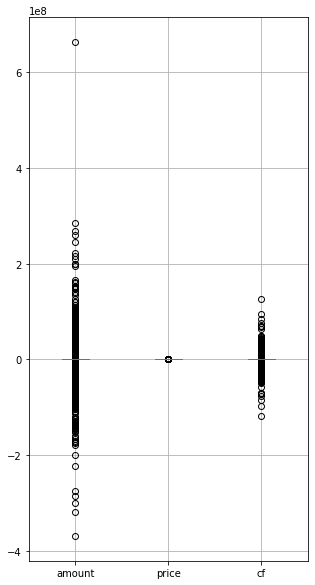

In [17]:
print(df_result.drop(["user"], axis=1).boxplot(figsize=(5, 10)))

AxesSubplot(0.125,0.125;0.775x0.755)


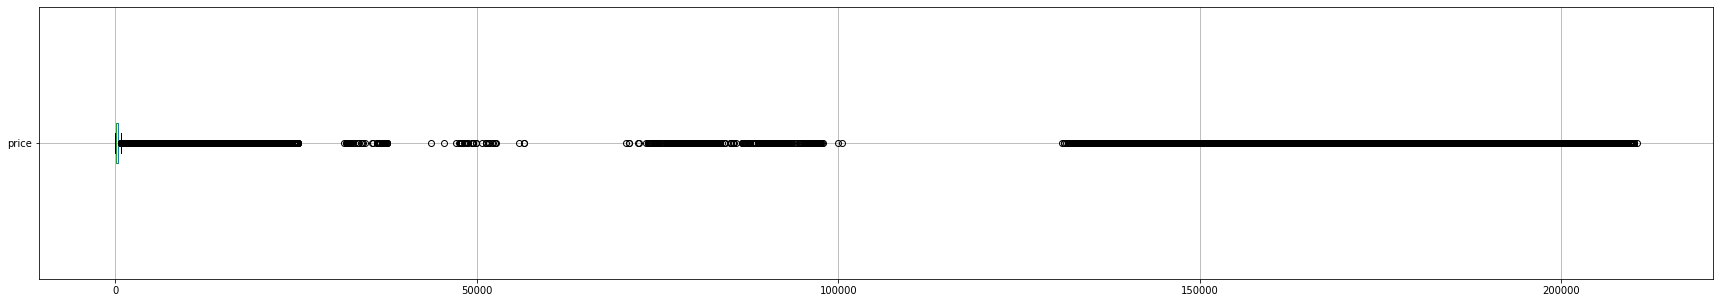

In [18]:
print(df_result.drop(["amount", "cf", "user"], axis=1).boxplot(figsize=(30, 5), vert=False))

В столбцах количественных переменных действительно много выбросов, особенно в цене акций и объеме сделки

C:\Users\isaev\AppData\Local\Temp\ipykernel_14644\1895811916.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_result.corr())


<AxesSubplot:>

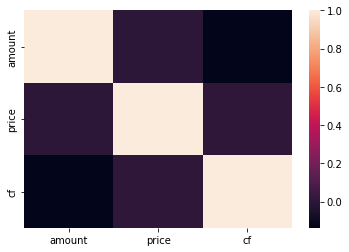

In [19]:
sns.heatmap(df_result.corr())

Все пары фичей мало коррелируют друг с другом; пара с небольшой корреляцией - пользователь и цена акции => пользователи при покупке акций немного ориентируются на ее цену. Еще меньше корреляции между юзером и количеством покупаемых акций, но она незначительна. А между полученной прибылью и пользователем корреляции нет. 

Теперь проанализируем категориальные переменные

In [21]:
print("Количество уникальных юзеров: ", df_result["user"].nunique())
print("Количество уникальных акций: ", df_result["ticker"].nunique())
print("Среднее количесво операций пользователей: ", df_result.shape[0] / df_result["user"].nunique())
print("Среднее количество операций с акциями: ", df_result.shape[0] / df_result["ticker"].nunique())

Количество уникальных юзеров:  42833
Количество уникальных акций:  161
Среднее количесво операций пользователей:  159.96843555202764
Среднее количество операций с акциями:  42558.55900621118


Посмотрим разброс активности пользователей по количеству совершенных операций

In [27]:
df_result['user'] = df_result['user'].astype(int)

In [28]:
user_sort_df = df_result.sort_values("user")
oper_count = 0
user_oper = []
for i in range(0, df_result.shape[0]-1):
    if df_result.user[i+1]!=df_result.user[i]:
        oper_count += 1
        user_oper.append(oper_count)
        oper_count = 0
    else: 
        oper_count += 1

In [29]:
if df_result.user[df_result.shape[0]-2]!=df_result.user[df_result.shape[0]-1]:
    user_oper.append(1)
else:
    user_oper[-1]+=1

<AxesSubplot:>

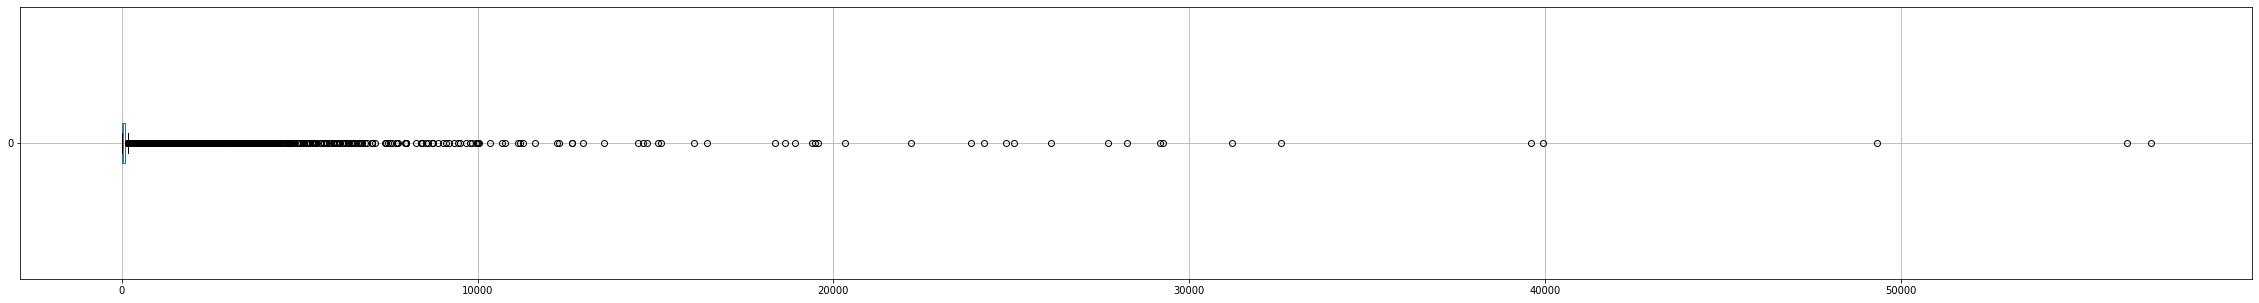

In [30]:
pd.DataFrame(user_oper).boxplot(figsize = (40, 5), vert=False)

[[<AxesSubplot:title={'center':'0'}>]] [[<AxesSubplot:title={'center':'0'}>]] [[<AxesSubplot:title={'center':'0'}>]]


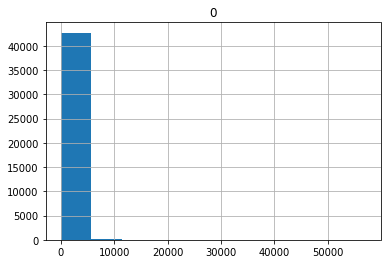

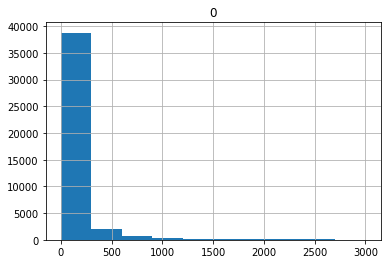

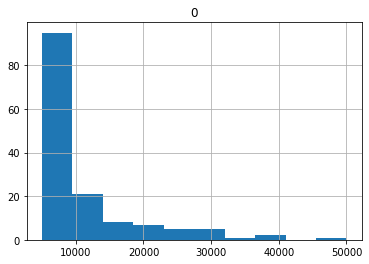

In [31]:
print(pd.DataFrame(user_oper).hist(), 
      pd.DataFrame(user_oper).hist(range=[0, 3000]), 
      pd.DataFrame(user_oper).hist(range=[5000, 50000]))

По гистограммам видно, что большая часть пользователей совершила до 500 операций, при этом есть сильные выбросы - пользователи, у которых от 5000 до 50000 операций с акциями, но их количество ~130. 

Теперь посчитаем разброс цен каждой акции

In [33]:
all_tick = dict()
range_tickers = dict()
for i in range(0, df_result.shape[0]):
    if df_result.ticker[i] not in all_tick.keys():
        all_tick[df_result.ticker[i]]=[]
    all_tick[df_result.ticker[i]].append(df_result.price[i])

In [34]:
for k in all_tick.keys():
    if len(all_tick[k])>1:
        range_tickers[k] = [min(all_tick[k]), max(all_tick[k])]

In [35]:
for k in range_tickers.keys():
    range_tickers[k] = range_tickers[k][1]-range_tickers[k][0]

In [36]:
sorted_ranges=sorted(range_tickers.items(), key=lambda x: x[1], reverse=True)

[[<AxesSubplot:title={'center':'0'}>]] [[<AxesSubplot:title={'center':'0'}>]]


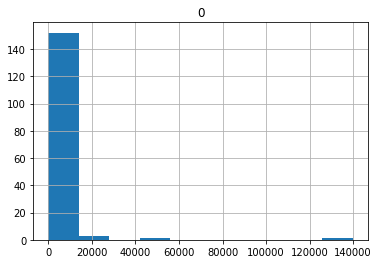

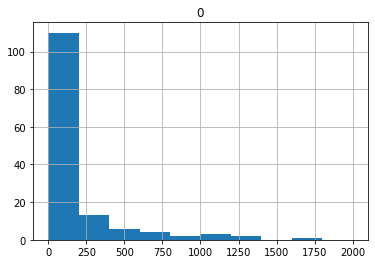

In [37]:
print(pd.DataFrame([i[1] for i in sorted_ranges]).hist(), 
      pd.DataFrame([i[1] for i in sorted_ranges]).hist(range=[0, 2000]))

Большая часть акций имеет размах в цене около 200, при это есть акции разница макс и мин цены которых около больше 100 000

In [38]:
print("Топ самых нестабильных акций: ", [i[0] for i in sorted_ranges][:10])
print("Топ самых стабильных акций: ", [i[0] for i in sorted_ranges][-11:-1])

Топ самых нестабильных акций:  ['TRNFP', 'VSMO', 'LNZL', 'GMKN', 'PLZL', 'MGNT', 'FXRU', 'PHOR', 'YNDX', 'TCSG']
Топ самых стабильных акций:  ['GOLD', 'SBCS', 'FEES', 'DASB', 'MRKP', 'AKMB', 'TTLK', 'VTBR', 'LQDT', 'TGKA']


# Подготовка данных

In [18]:
tick2ind = {ticker:i for i, ticker in enumerate(df_result.ticker.unique())}
ind2tick = {val:key for key, val in tick2ind.items()}
df_result['new_ticker'] = df_result['ticker'].apply(lambda x: tick2ind[x])

user2ind = {user:i for i, user in enumerate(df_result.user.unique())}
ind2user = {val:key for key, val in user2ind.items()}
df_result['new_user'] = df_result['user'].apply(lambda x: user2ind[x])


print(df_result.shape)
df_result.sample(10)

(6851928, 10)


,datetime,ticker,amount,price,user,cf,date,value,new_ticker,new_user
2499359,2016-12-08 14:09:00,SBER,-100,164.59000,1_98604,16459.0,2016-12-08,-16459.0,23,10842
2396269,2016-11-23 14:20:00,RSTI,-1000,1.12780,1_87052,1127.8,2016-11-23,-1127.8,151,10336
972333,2015-10-30 13:05:00,SBER,-10,90.20000,1_62450,902.0,2015-10-30,-902.0,23,3090
622778,2022-11-10 10:00:00,VTBR,190000,0.01672,313922,-3176.8,2022-11-10,3176.8,20,1576
5786631,2020-12-02 22:31:00,MAIL,-9,2164.20000,1_246028,19477.8,2020-12-02,-19477.8,158,28399
161687,2022-10-21 16:34:00,VTBR,980000,0.01614,311651,-15817.2,2022-10-21,15817.2,20,222
4662712,2019-10-24 13:56:00,TATNP,3,654.00000,1_220582,-1962.0,2019-10-24,1962.0,13,20750
2953275,2016-10-05 11:57:00,GMKN,-10,9480.00000,1_88341,94800.0,2016-10-05,-94800.0,17,13144
2056749,2015-11-09 13:09:00,OGKB,3000,0.21330,1_53177,-639.9,2015-11-09,639.9,89,8583
4450996,2018-12-17 12:57:00,MOEX,60,84.41000,1_189749,-5064.6,2018-12-17,5064.6,31,19459


### Создаем словарь (Дата сделки: сделка)

In [19]:
def date_deals(df, data):    
    
    """
    Функция получает на вход столбец датафрейма с датами сделок
    
    На выходе: словарь с ключами - Дата сделки, а значения - сами сделки
    """
    
    date_deal = {}
    dates=set(data.values)
    
    for d in dates:
        deals = df[(data==d)]
        if len(deals)==1:
            continue
        else:
            date_deal[d] = deals    
            
    return date_deal

# Train_test_split

In [20]:
def train_test_split(train_size=0.7, test_size=0.3):
    
    train = pd.DataFrame()
    test = pd.DataFrame()
    dict_date = date_deals(df_result, df_result["date"])
    
    for key in dict_date.keys():
        deals_count = len(dict_date[key])
        to_train = round(deals_count*train_size)
        to_test = round(deals_count*test_size)
            
        train = pd.concat([train, dict_date[key][:to_train]])
        test = pd.concat([test, dict_date[key][-to_test:]])
    return (train, test)

In [21]:
%%time
train, test = train_test_split(train_size=0.7, test_size=0.3)

CPU times: total: 1min 22s
Wall time: 1min 23s


In [22]:
train.shape

(4796337, 10)

In [23]:
test.shape

(2055593, 10)

In [28]:
train.head(10)

,datetime,ticker,amount,price,user,cf,date,value,new_ticker,new_user
0,2022-09-29 18:20:00,SPBE,420,118.800,312438,-49896.0,2022-09-29,49896.0,0,0
396,2022-09-29 11:23:00,POSI,1,1063.400,311657,-1063.4,2022-09-29,1063.4,2,3
397,2022-09-29 11:23:00,POSI,1,1063.400,311657,-1063.4,2022-09-29,1063.4,2,3
398,2022-09-29 11:23:00,POSI,3,1063.600,311657,-3190.8,2022-09-29,3190.8,2,3
399,2022-09-29 11:23:00,POSI,12,1063.600,311657,-12763.2,2022-09-29,12763.2,2,3
400,2022-09-29 11:23:00,POSI,1,1063.600,311657,-1063.6,2022-09-29,1063.6,2,3
401,2022-09-29 11:23:00,POSI,5,1063.600,311657,-5318.0,2022-09-29,5318.0,2,3
402,2022-09-29 11:23:00,POSI,1,1063.600,311657,-1063.6,2022-09-29,1063.6,2,3
403,2022-09-29 11:24:00,POSI,1,1063.600,311657,-1063.6,2022-09-29,1063.6,2,3
404,2022-09-29 11:25:00,SGZH,3000,5.191,311657,-15573.0,2022-09-29,15573.0,8,3


In [27]:
test.head(10)

,datetime,ticker,amount,price,user,cf,date,value,new_ticker,new_user
436964,2022-09-29 15:47:00,SBER,-10,108.52,311399,1085.2,2022-09-29,-1085.2,23,1049
436965,2022-09-29 15:47:00,SBER,-2500,108.52,311399,271300.0,2022-09-29,-271300.0,23,1049
436966,2022-09-29 15:47:00,SBER,-20,108.51,311399,2170.2,2022-09-29,-2170.2,23,1049
436967,2022-09-29 15:47:00,SBER,-200,108.51,311399,21702.0,2022-09-29,-21702.0,23,1049
436968,2022-09-29 15:47:00,SBER,-500,108.50,311399,54250.0,2022-09-29,-54250.0,23,1049
436969,2022-09-29 15:47:00,SBER,-610,108.50,311399,66185.0,2022-09-29,-66185.0,23,1049
436970,2022-09-29 15:47:00,SBER,-1000,108.50,311399,108500.0,2022-09-29,-108500.0,23,1049
436971,2022-09-29 15:47:00,SBER,-1000,108.50,311399,108500.0,2022-09-29,-108500.0,23,1049
436972,2022-09-29 15:47:00,SBER,-1000,108.50,311399,108500.0,2022-09-29,-108500.0,23,1049
436973,2022-09-29 15:47:00,SBER,-1000,108.50,311399,108500.0,2022-09-29,-108500.0,23,1049
